<a href="https://colab.research.google.com/github/kheireldine/Machine-learning-Projects/blob/main/CV_Image_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Classifier
In this project we will be creating a classifier of iamges based on a dataset of dogs and cats

Fristly, we need to import the required data libraries and for now we need only tensorflow and keras (Keras will be imported from tensorflow and keras.layers from keras(tensorflow.keras))

In [1]:
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers

Libraries are ready now, we need to download and import data. 
Note that we are using ready dataset, so we will download it from microsoft

In [2]:
#Download 
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
#Unzip
!unzip -q kagglecatsanddogs_3367a.zip
!ls

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0  91.6M      0  0:00:08  0:00:08 --:--:-- 89.8M
 kagglecatsanddogs_3367a.zip   PetImages        sample_data
'MSR-LA - 3467.docx'	      'readme[1].txt'


We have 2 folders are PetImages and sample_data. We will read what's inside them.


In [3]:
!ls PetImages

Cat  Dog


In [4]:
!ls sample_data

anscombe.json		      mnist_test.csv
california_housing_test.csv   mnist_train_small.csv
california_housing_train.csv  README.md


We need only the files inside PetImages for now

Corrupted images are a common occurence. Let's filter out badly-encoded images that do not feature the string "JFIF" in their header.

In [5]:
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 1590 images


We deleted 1590 corrupted images and now we have the data clean.
Next, we will create the dataset
Batch size is a term used in machine learning and refers to the number of training examples utilized in one iteration.[Batch Size](https://radiopaedia.org/articles/batch-size-machine-learning)

In [6]:
#Image size specified to be (180, 180) and we need all the images to have the same dimenssions
image_size = (180, 180)
#The batch size means the number of images processed at the same time
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    #As we mentioned we are working on the PetImages folder and we will split data 80/20 between training and validation, that's why we are setting the validation_split to 0.2
    "PetImages",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


The previous section demonstrated that we have 23410 files which belonging to 2 classes we are working on are dog and class. 
Also, we splited the dataset 80/20. that's why we found 18728 files for training and 4628 files for validation

**We should see the data and make sure they are in the apropriate and expected format according to the cpnfiguration we already did**


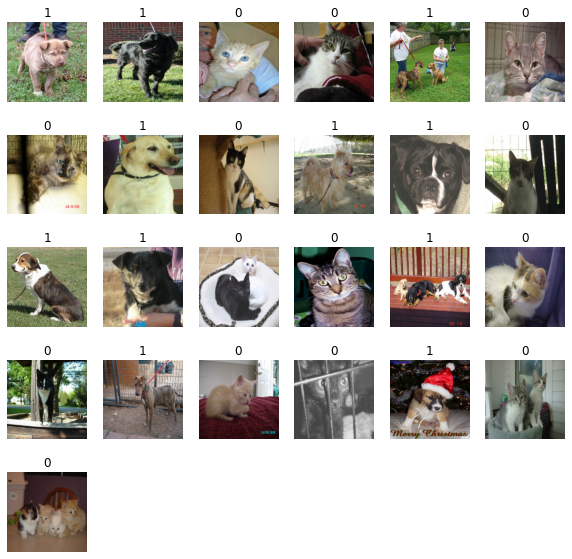

In [7]:
#now we will import matplotlib to visualize data added to the imported libraries at the beginning of the project
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
# The fig suze will not affect the number of images displayed. So if we want to display more or less photos we don't need to change the size
for images, labels in train_ds.take(1):
    for i in range(25):
        #range(a). a is the number of photos we want to display 
        #ax = plt.subplot(5, 5, i + 1)
        #we want to display more than one image so we have to make subplots, in this case we choose the shape of display but we should make sure that subplot(b,c,d) b*c >=a. 
        #so we can choose the shape that we want and we will try that in the upcoming code
        #ax = plt.subplot(1, 25, i + 1)
        #ax = plt.subplot(15, 2, i + 1)
        ax = plt.subplot(5, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

**Here we don't have a lot of iamges. So it is a good pratcise to do data augmentation**.

**[Data Augementation](https://en.wikipedia.org/wiki/Data_augmentation)**: in data analysis are techniques used to increase the amount of data by adding slightly modified copies of already existing data or newly created synthetic data from existing data. It acts as a regularizer and helps reduce overfitting when training a machine learning mode.
Note that sometimes we use data augmentation to reduce ovefitting


In [8]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

We will see next how our data changed after we applied data augmentation

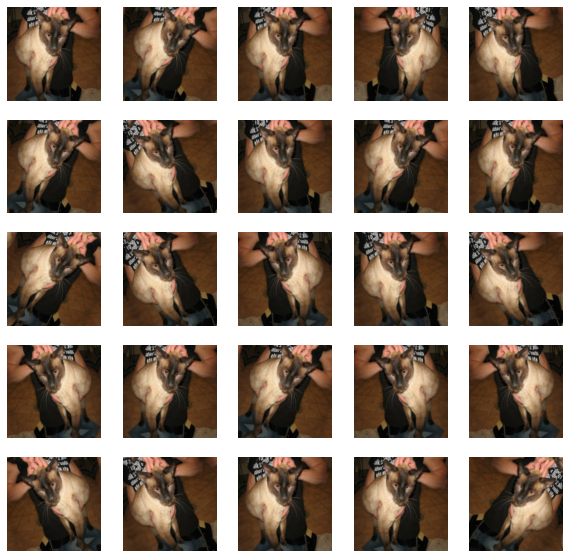

In [9]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(25):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

Now we increased the amount of images in our dataset. What's Next ?
 As we know about neural networks they prefer low numbers and ranges and it performs better with small scales. That's why we will do standardization.

**[Standardization](https://www.analyticsvidhya.com/blog/2020/04/feature-scaling-machine-learning-normalization-standardization/)**
Standardization is another scaling technique where the values are centered around the mean with a unit standard deviation. This means that the mean of the attribute becomes zero and the resultant distribution has a unit standard deviation. 



In [10]:
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

#or 
#inputs = keras.Input(shape=input_shape)
#x = data_augmentation(inputs)
#x = layers.Rescaling(1./255)(x)

**Configure the dataset for performance**
Let's make sure to use buffered prefetching so we can yield data from disk without having I/O becoming blocking


In [11]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

# Let's build our model

Note that:

We start the model with the data_augmentation preprocessor, followed by a Rescaling layer.
We include a Dropout layer before the final classification layer.

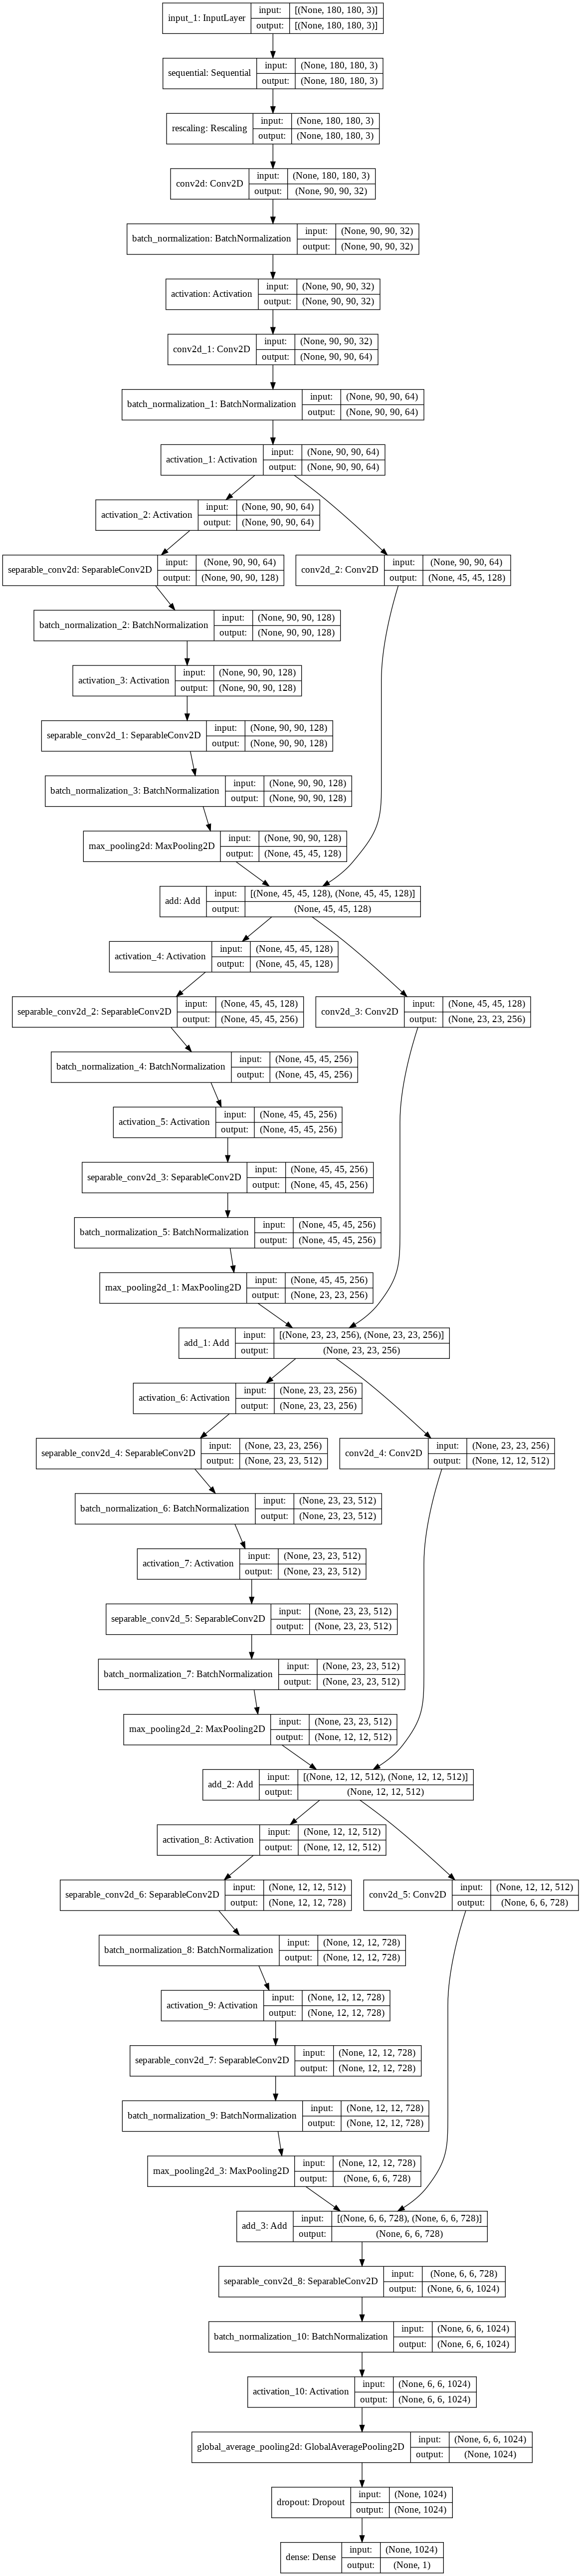

In [12]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block (We already prepared the function)
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

# Train the model

In [13]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

# Testing on New Data
Note that we are not using data augmentation here and it will be unative.

In [13]:
img = keras.preprocessing.image.load_img(
    "PetImages/Cat/6779.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)